# __Austin House Price Prediction__

### __1.Enviroment Set-up & Data Preprocessing__

#### 1.1 Setup Google Colab for Spark

In [1]:
# Install Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #Install java
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz ## Install Apache Spark
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=6c804c9b58f3b9b6232ac947ffc1db5dbe287473b6381f3c47e90a34a89639ec
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
import os
from pyspark.sql import SparkSession
# Define Java and Spark home path in Google Colab
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()

# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Austin House Price Prediction") \
    .getOrCreate()

#### 1.2 Load the Dataset

When uploading CSV file to Spark, We encountered an issue where many data entries were not read correctly, resulting in numerous null values. To address this, We decided to transform the dataset's format from CSV to Parquet, as Parquet is a columnar storage file format optimized for such tasks, and finally we solved this problem.

In [4]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/Shared drives/423/Final Project/austinHousingData.csv')

# Convert pandas DataFrame to Parquet format
df.to_parquet('/content/drive/Shared drives/423/Final Project/austinHousingData.parquet')

In [6]:
# Load the Parquet file into Spark DataFrame
file_path = "/content/drive/Shared drives/423/Final Project/austinHousingData.parquet"
df = spark.read.parquet(file_path)

# Display the first few rows
df.show(5)

+----------+------------+--------------------+-------+--------------------+------------------+------------------+---------------+------------+--------------+----------+---------+----------+------+-------+-------------+-------------+---------+-----------+---------------+---------------+----------------+---------------+--------------------+-----------+--------------------------+---------------+--------------------+--------------------------+---------------------+-----------------------+-------------------+----------------------+-----------+--------------+-------------------+----------------------+------------------+----------------+------------------+------------------+-------------+------------------------+--------------+-------------+------------+--------------------+
|      zpid|        city|       streetAddress|zipcode|         description|          latitude|         longitude|propertyTaxRate|garageSpaces|hasAssociation|hasCooling|hasGarage|hasHeating|hasSpa|hasView|     homeType|par

#### 1.3 Data Selection

In [7]:
# Filter the DataFrame to retain only Austin data
austin_df = df.filter(df.city == "austin")
austin_df.show(5)

+---------+------+--------------------+-------+--------------------+------------------+------------------+---------------+------------+--------------+----------+---------+----------+------+-------+-------------+-------------+---------+-----------+---------------+---------------+----------------+---------------+-----------------+-----------+--------------------------+---------------+--------------------+--------------------------+---------------------+-----------------------+-------------------+----------------------+-----------+--------------+-------------------+----------------------+------------------+----------------+------------------+------------------+-------------+------------------------+--------------+-------------+------------+--------------------+
|     zpid|  city|       streetAddress|zipcode|         description|          latitude|         longitude|propertyTaxRate|garageSpaces|hasAssociation|hasCooling|hasGarage|hasHeating|hasSpa|hasView|     homeType|parkingSpaces|yearBu

#### 1.4 Handling Missing Values

In [8]:
from pyspark.sql.functions import col, sum, count, when

# Check for missing values in each column
null_values = austin_df.select([count(when(col(c).isNull(), c)).alias(c) for c in austin_df.columns])
null_values.show()

+----+----+-------------+-------+-----------+--------+---------+---------------+------------+--------------+----------+---------+----------+------+-------+--------+-------------+---------+-----------+---------------+---------------+----------------+---------------+-----------------+-----------+--------------------------+---------------+--------------------+--------------------------+---------------------+-----------------------+-------------------+----------------------+-----------+--------------+-------------------+----------------------+------------------+----------------+-----------------+---------------+-------------+------------------------+--------------+-------------+------------+---------+
|zpid|city|streetAddress|zipcode|description|latitude|longitude|propertyTaxRate|garageSpaces|hasAssociation|hasCooling|hasGarage|hasHeating|hasSpa|hasView|homeType|parkingSpaces|yearBuilt|latestPrice|numPriceChanges|latest_saledate|latest_salemonth|latest_saleyear|latestPriceSource|numOfPhoto

There are only two rows having missing values, so we decided to drop these two rows.

In [9]:
# Drop rows with missing values
austin_df = austin_df.dropna()

# Verify that there are no more missing values
null_values = austin_df.select([count(when(col(c).isNull(), c)).alias(c) for c in austin_df.columns])
null_values.show()

+----+----+-------------+-------+-----------+--------+---------+---------------+------------+--------------+----------+---------+----------+------+-------+--------+-------------+---------+-----------+---------------+---------------+----------------+---------------+-----------------+-----------+--------------------------+---------------+--------------------+--------------------------+---------------------+-----------------------+-------------------+----------------------+-----------+--------------+-------------------+----------------------+------------------+----------------+-----------------+---------------+-------------+------------------------+--------------+-------------+------------+---------+
|zpid|city|streetAddress|zipcode|description|latitude|longitude|propertyTaxRate|garageSpaces|hasAssociation|hasCooling|hasGarage|hasHeating|hasSpa|hasView|homeType|parkingSpaces|yearBuilt|latestPrice|numPriceChanges|latest_saledate|latest_salemonth|latest_saleyear|latestPriceSource|numOfPhoto

#### 1.5 Dropping Irrelevant Columns

Since we filtered the data to Austin only, we can drop this column. garageSpaces and parkingSpaces are the same, so we only keep one of them. Latitude and longitude were used and plotted in Tableau, since they are not appropriate to be used in model, we dropped them as well.

In [10]:
# Drop columns that are not useful for the prediction
columns_to_drop = ['zpid', 'city', 'streetAddress', 'latitude', 'longitude', 'garageSpaces', 'latest_saledate', 'latest_salemonth', 'homeImage']
austin_df = austin_df.drop(*columns_to_drop)
austin_df.show(5)

+-------+--------------------+---------------+--------------+----------+---------+----------+------+-------+-------------+-------------+---------+-----------+---------------+---------------+-----------------+-----------+--------------------------+---------------+--------------------+--------------------------+---------------------+-----------------------+-------------------+----------------------+-----------+--------------+-------------------+----------------------+------------------+----------------+------------------+------------------+-------------+------------------------+--------------+-------------+------------+
|zipcode|         description|propertyTaxRate|hasAssociation|hasCooling|hasGarage|hasHeating|hasSpa|hasView|     homeType|parkingSpaces|yearBuilt|latestPrice|numPriceChanges|latest_saleyear|latestPriceSource|numOfPhotos|numOfAccessibilityFeatures|numOfAppliances|numOfParkingFeatures|numOfPatioAndPorchFeatures|numOfSecurityFeatures|numOfWaterfrontFeatures|numOfWindowFeatur

#### 1.6 Transform Boolean Columns

In [11]:
from pyspark.sql.functions import when

# List of boolean columns to transform
boolean_columns = ["hasAssociation", "hasCooling", "hasGarage", "hasHeating", "hasSpa", "hasView"]

# Transform 'True' to 1 and 'False' to 0
for column in boolean_columns:
    austin_df = austin_df.withColumn(column, when(col(column) == True, 1).when(col(column) == False, 0))

# Verify the transformations
austin_df.select(boolean_columns).show(5)

+--------------+----------+---------+----------+------+-------+
|hasAssociation|hasCooling|hasGarage|hasHeating|hasSpa|hasView|
+--------------+----------+---------+----------+------+-------+
|             1|         1|        0|         1|     0|      0|
|             1|         1|        1|         1|     0|      1|
|             0|         1|        1|         1|     0|      0|
|             1|         1|        0|         1|     0|      0|
|             1|         1|        1|         1|     0|      0|
+--------------+----------+---------+----------+------+-------+
only showing top 5 rows



---

### __2.Exploratory Data Analysis (EDA)__

In [12]:
# Descriptive statistics
austin_df.describe().show()

+-------+------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+--------------------------+------------------+--------------------+--------------------------+---------------------+-----------------------+-------------------+----------------------+--------------------+------------------+-------------------+----------------------+------------------+-------------------+------------------+------------------+------------------+------------------------+------------------+------------------+------------------+
|summary|           zipcode|         description|     propertyTaxRate|     hasAssociation|         hasCooling|          hasGarage|         hasHeating|             hasSpa|            hasView|   homeType|     parkingSpaces| 

In [13]:
# Analysis of categorical features
austin_df.groupBy("homeType").count().show()

+--------------------+-----+
|            homeType|count|
+--------------------+-----+
|           Apartment|   36|
|           Townhouse|  174|
|         Vacant Land|   81|
|  Multiple Occupancy|   96|
|         Residential|   37|
|               Other|    6|
|         MultiFamily|   10|
|       Single Family|14094|
|               Condo|  467|
|Mobile / Manufact...|   17|
+--------------------+-----+



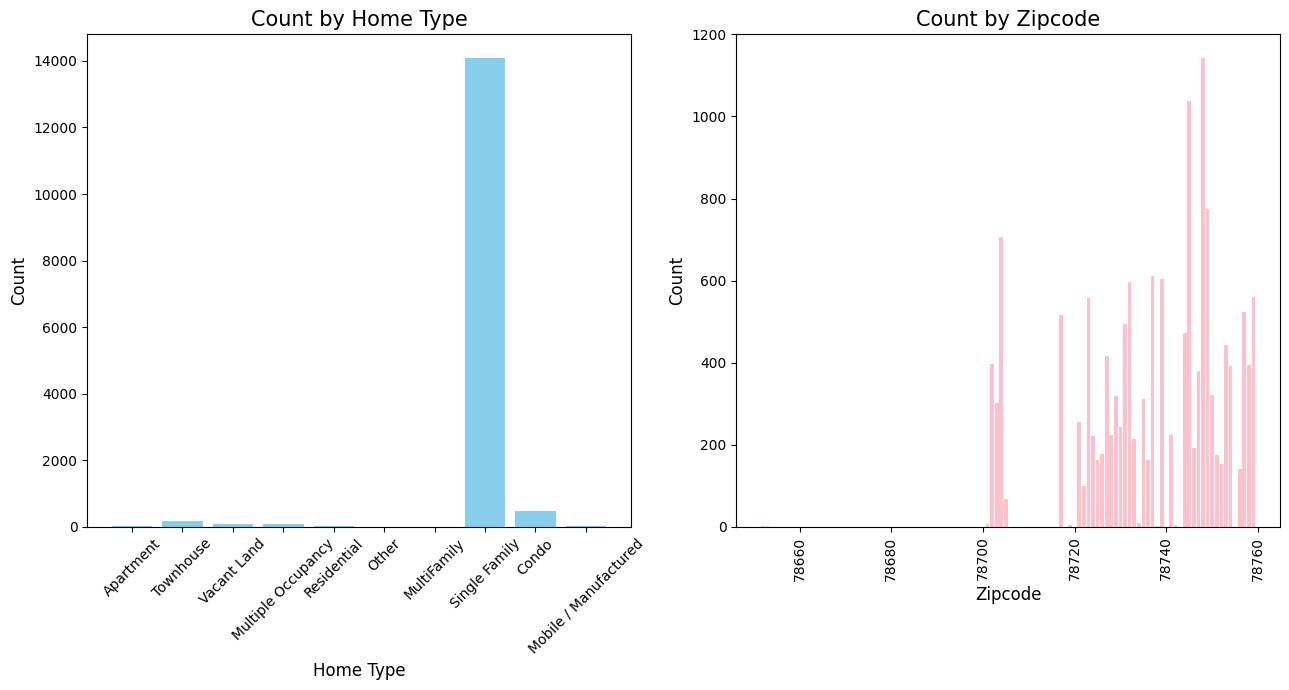

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert relevant columns to Pandas DataFrame for visualization
home_type_df = austin_df.groupBy("homeType").count().toPandas()
zipcode_df = austin_df.groupBy("zipcode").count().toPandas()

# Set up the plotting area
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

# Plot bar chart for homeType
axes[0].bar(home_type_df['homeType'], home_type_df['count'], color='skyblue')
axes[0].set_title('Count by Home Type', fontsize=15)
axes[0].set_xlabel('Home Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot bar chart for zipcode
axes[1].bar(zipcode_df['zipcode'], zipcode_df['count'], color='pink')
axes[1].set_title('Count by Zipcode', fontsize=15)
axes[1].set_xlabel('Zipcode', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

__Insights:__ The majority of properties are Single Family homes, followed by Condos.The properties are concentrated in certain zip codes, with the highest counts in the 78745 and 78748 areas.

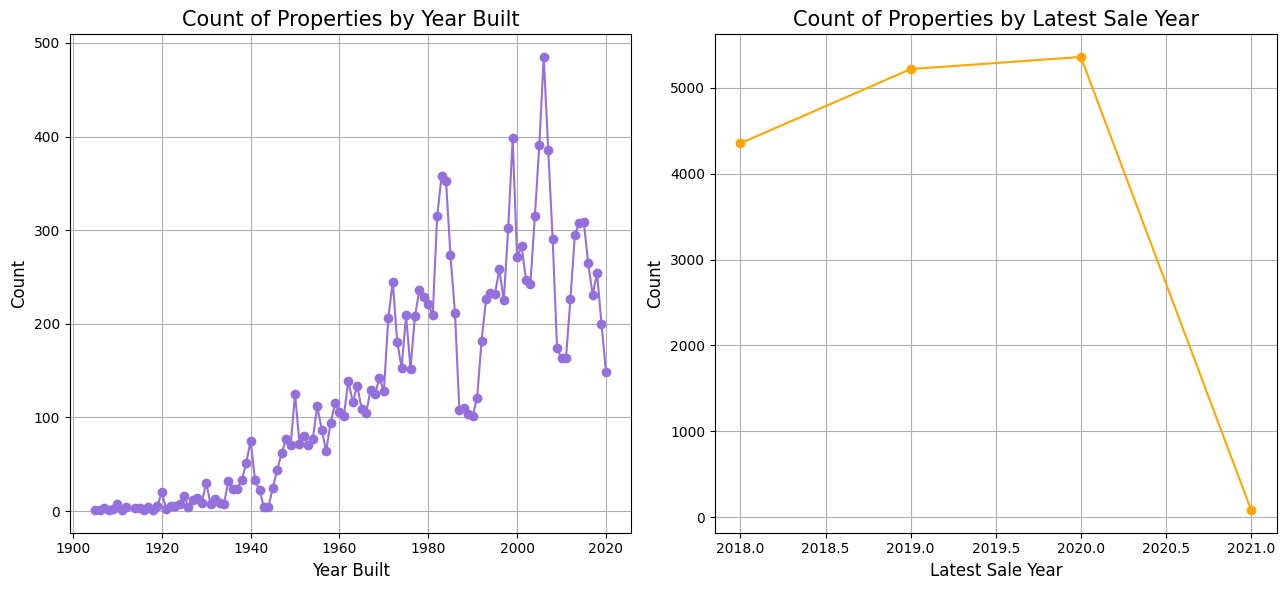

In [15]:
# Convert relevant columns to Pandas DataFrame for visualization
year_built_df = austin_df.groupBy("yearBuilt").count().orderBy("yearBuilt").toPandas()
latest_sale_year_df = austin_df.groupBy("latest_saleyear").count().orderBy("latest_saleyear").toPandas()

# Set up the plotting area
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot line chart for yearBuilt
axes[0].plot(year_built_df['yearBuilt'], year_built_df['count'], color='mediumpurple', marker='o')
axes[0].set_title('Count of Properties by Year Built', fontsize=15)
axes[0].set_xlabel('Year Built', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(True)

# Plot line chart for latest_saleyear
axes[1].plot(latest_sale_year_df['latest_saleyear'], latest_sale_year_df['count'], color='orange', marker='o')
axes[1].set_title('Count of Properties by Latest Sale Year', fontsize=15)
axes[1].set_xlabel('Latest Sale Year', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

__Insights:__ There is an increasing trend in the number of properties built from the early 1900s to the 2000s, peaking around 2005. Post-2010, there is a slight decline in new constructions. Most sales are recent, with peaks around 2018-2020, indicating a high turnover of properties in recent years.

In [16]:
import seaborn as sns

# Convert to Pandas DataFrame for visualization
pandas_df = austin_df.toPandas()

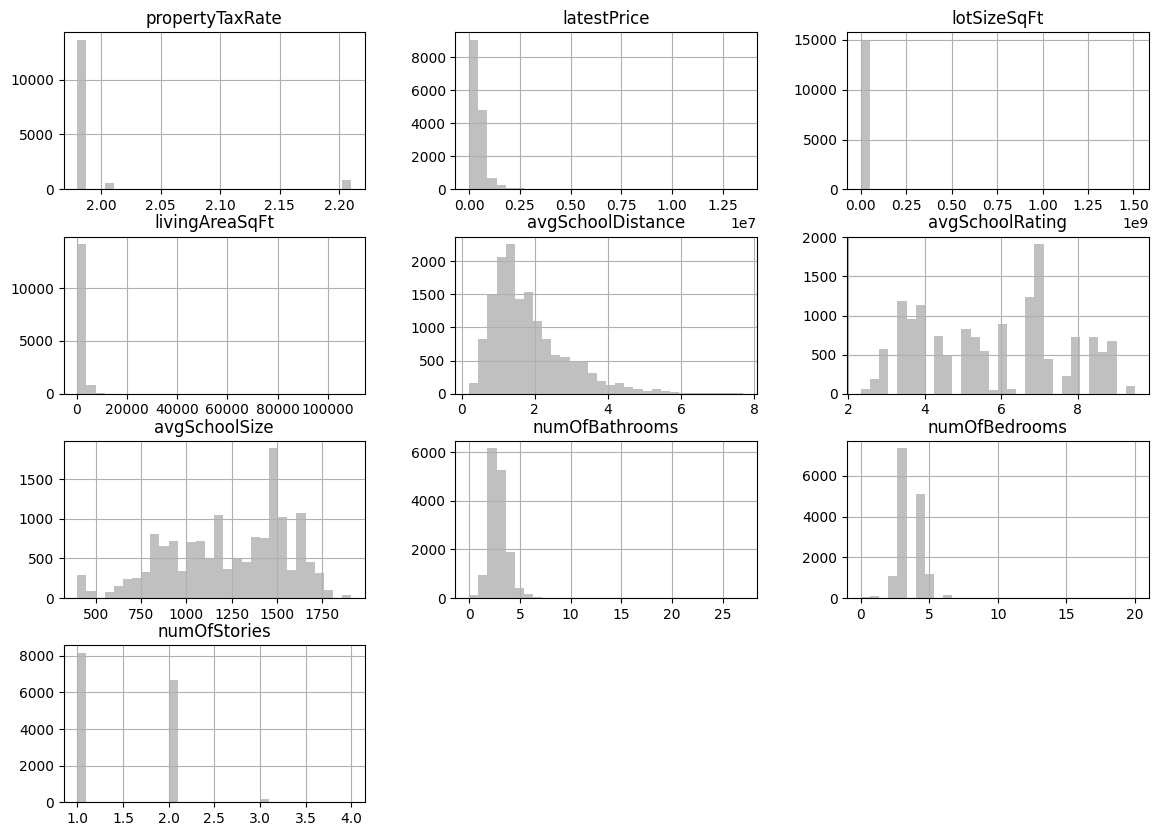

In [17]:
# Distribution of numerical features
num_cols = ["propertyTaxRate", "latestPrice", "lotSizeSqFt", "livingAreaSqFt", "avgSchoolDistance",
            "avgSchoolRating", "avgSchoolSize", "numOfBathrooms", "numOfBedrooms", "numOfStories"]

num_cols_df = pandas_df[num_cols]

# Plot histograms for numerical features
num_cols_df.hist(bins=30, figsize=(14, 10), color='silver')
plt.show()

__Insights:__ The majority of properties have lot sizes less than 20,000 SqFt, with a significant number of smaller lot sizes. Living areas are mostly below 5,000 SqFt, with a few outliers having much larger living spaces.

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np

# Assemble the columns into a feature vector
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=num_cols, outputCol=vector_col)
df_vector = assembler.transform(austin_df).select(vector_col)

# Compute the correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
corr_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].values
corr_matrix = np.array(corr_matrix).reshape(len(num_cols), len(num_cols))

# Convert to Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix, index=num_cols, columns=num_cols)

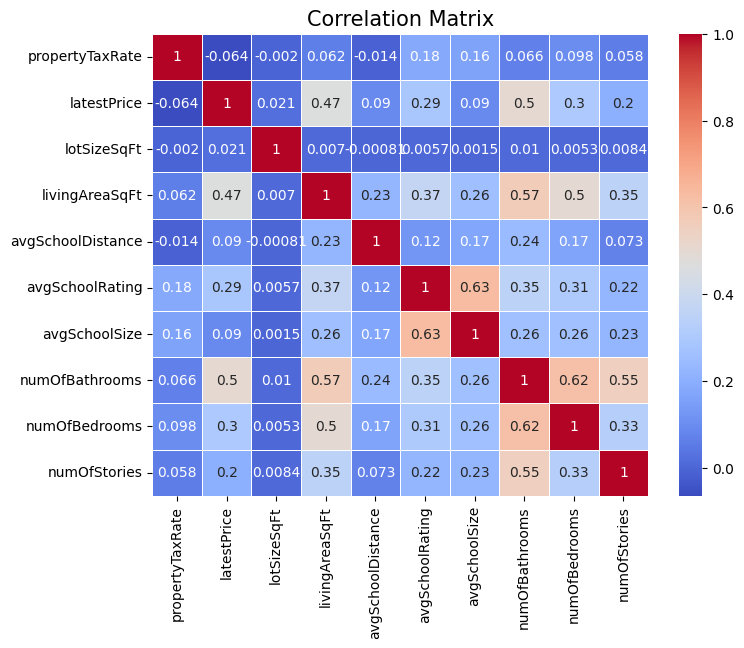

In [19]:
# Draw the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=15)
plt.show()

__Insights:__
- `Living Area` and `Latest Price`: Strong positive correlation (0.47), indicating larger living areas generally have higher prices.  

- `Number of Bathrooms` and `Bedrooms`: Moderate to strong positive correlations with latest price, living area, and each other.  

- `Average School Rating` and `School Size`: Moderate positive correlation with each other and with property prices, suggesting properties in areas with larger and higher-rated schools tend to be more expensive.

### __3.Sentiment Analysis__

Utilizing Natural Language Processing knowledge, we performed sentiment analysis on the description column, transformed it into sentiment score ranging from 0-5, which could further be used in prediction model.

In [ ]:
from transformers import pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Initialize the sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that aut

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# Define a UDF to perform sentiment analysis and scale the score to 0-5
def analyze_sentiment(text):
    result = sentiment_analysis(text)[0]
    score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    scaled_score = (score + 1) * 2.5  # Scale to 0-5
    rounded_score = np.round(scaled_score, 0)  # Round to integer
    return float(rounded_score)

# Register the UDF
sentiment_udf = udf(analyze_sentiment, DoubleType())

# Apply the UDF to the 'description' column
df_new = austin_df.withColumn("sentiment_score", sentiment_udf(austin_df["description"]))

# Show the resulting DataFrame with sentiment scores
df_new.select("description", "sentiment_score").show()

+--------------------+---------------+
|         description|sentiment_score|
+--------------------+---------------+
|*PLEASE SEE THE W...|            5.0|
|Rare opportunity ...|            5.0|
|Charming Home boa...|            5.0|
|COVETED, SPACIOUS...|            5.0|
|Stunning Modern D...|            5.0|
|Popular Bingham F...|            5.0|
|Contact first lis...|            0.0|
|Fridge, washer, d...|            0.0|
|15303 Lucian St, ...|            1.0|
|Avery Ranch 3 car...|            5.0|
|Don't miss this o...|            5.0|
|Welcome to the Es...|            5.0|
|Sitting on 2.34 a...|            5.0|
|5509 Bonneville B...|            0.0|
|10912 Crosbyton L...|            1.0|
|Awesome opportuni...|            5.0|
|Very close to Aus...|            5.0|
|An abundance of t...|            5.0|
|Great home availa...|            5.0|
|A well kept 3 bed...|            5.0|
+--------------------+---------------+
only showing top 20 rows



### __4.Linear Regression Model__

#### 4.1 Variable Encoding

In [20]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Drop the description column
df_new = austin_df.drop('description')

# Indexing categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "Index")
    for col in ["zipcode", "homeType", "latestPriceSource"]
]

# One-Hot Encoding indexed columns
encoders = [
    OneHotEncoder(inputCol=col + "Index", outputCol=col + "Vec")
    for col in ["zipcode", "homeType", "latestPriceSource"]
]

# Create a pipeline to index and encode
pipeline = Pipeline(stages=indexers + encoders)
df_new = pipeline.fit(df_new).transform(df_new)

# Drop original categorical columns and their indexes
df_new = df_new.drop("zipcode", "homeType", "latestPriceSource", "zipcodeIndex", "homeTypeIndex", "latestPriceSourceIndex")

# Check the new data
df_new.show(10)

+---------------+--------------+----------+---------+----------+------+-------+-------------+---------+-----------+---------------+---------------+-----------+--------------------------+---------------+--------------------+--------------------------+---------------------+-----------------------+-------------------+----------------------+-----------+--------------+-------------------+----------------------+------------------+----------------+------------------+------------------+-------------+------------------------+--------------+-------------+------------+---------------+-------------+--------------------+
|propertyTaxRate|hasAssociation|hasCooling|hasGarage|hasHeating|hasSpa|hasView|parkingSpaces|yearBuilt|latestPrice|numPriceChanges|latest_saleyear|numOfPhotos|numOfAccessibilityFeatures|numOfAppliances|numOfParkingFeatures|numOfPatioAndPorchFeatures|numOfSecurityFeatures|numOfWaterfrontFeatures|numOfWindowFeatures|numOfCommunityFeatures|lotSizeSqFt|livingAreaSqFt|numOfPrimarySchool

#### 4.2 Linear Regression with all variables

In [21]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import log, exp, col, sum as spark_sum
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Use log y
df_new = df_new.withColumn("log_latestPrice", log("latestPrice"))

# Specify feature columns (excluding the target column)
feature_cols = df_new.columns
feature_cols.remove("latestPrice")
feature_cols.remove("log_latestPrice")
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create and train the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="log_latestPrice")
pipeline = Pipeline(stages=[vectorAssembler, lr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=1234)
lr_model = pipeline.fit(train_data)

# Print model summary details
training_summary = lr_model.stages[-1].summary
print("Coefficients: " + str(lr_model.stages[-1].coefficients))
print("Intercept: " + str(lr_model.stages[-1].intercept))
print("---------------------------------------------------------")
print("Train RMSE: %f" % training_summary.rootMeanSquaredError)
print("Train r2: %f" % training_summary.r2)
print("Train MSE: %f" % training_summary.meanSquaredError)
print("Train MAE: %f" % training_summary.meanAbsoluteError)
print("---------------------------------------------------------")

# Predict on test data
predictions = lr_model.transform(test_data)

# Calculate RMSE, R2, MSE, and MAE
evaluator_rmse = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="r2")
evaluator_mse = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print("Test RMSE: %f" % rmse)
print("Test R2: %f" % r2)
print("Test MSE: %f" % mse)
print("Test MAE: %f" % mae)
print("---------------------------------------------------------")

# Convert log_y predictions back to y and calculate sum differences
predictions = predictions.withColumn("predicted_latestPrice", exp(col("prediction")))
predictions = predictions.withColumn("actual_latestPrice", exp(col("log_latestPrice")))

# Calculate the sum of actual and predicted values
sum_actual = predictions.agg(spark_sum("actual_latestPrice")).collect()[0][0]
sum_predicted = predictions.agg(spark_sum("predicted_latestPrice")).collect()[0][0]

print("Sum of actual latestPrice: %f" % sum_actual)
print("Sum of predicted latestPrice: %f" % sum_predicted)
print("Difference between actual and predicted sums: %f" % (sum_predicted - sum_actual))

Coefficients: [-1.1072642523888934,-0.04589751187821143,0.0478452778382048,-0.07467292569733858,-0.03544078471783504,0.05630003523922667,0.02043812214816258,0.029356818640224807,0.0013239798088955262,-0.03257710497368262,0.01939583846805395,0.0014815233967783927,0.0174073520109077,-0.0002524134528234379,0.015787731651727643,0.01484473224643253,0.0057937841989561725,0.43830161252524796,0.013854363439104976,-0.030379275345164183,1.1285018474980673e-10,5.085996569726344e-05,-0.11940964700259803,-0.06903170921704793,-0.0636678711694447,0.14534416900172087,0.025723089176584817,0.04975937708451253,-0.00015709762682654946,0.011096901271351786,0.17223858166115666,0.03907245149747954,-0.05859187430270324,-0.20801302918087466,-0.05356478033322562,-0.13835535669010984,0.6180022195111207,-0.14792010333652927,-0.07787944758940733,-0.10072955538779035,0.09163940766827973,0.07649818024657483,0.23830530667002323,-0.0022196957484222923,0.40760680724772286,-0.35209623845929733,-0.307949680957458,-0.1304

#### 4.3 Linear Regression with Lasso Regularization

In [22]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import log, exp, col, sum as spark_sum
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Use log y
df_new = df_new.withColumn("log_latestPrice", log("latestPrice"))

# Specify feature columns (excluding the target column)
feature_cols = df_new.columns
feature_cols.remove("latestPrice")
feature_cols.remove("log_latestPrice")
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create and train the linear regression model with Lasso regression parameters
lr = LinearRegression(featuresCol="features", labelCol="log_latestPrice", regParam=0.05, elasticNetParam=1.0)
pipeline = Pipeline(stages=[vectorAssembler, lr])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=1234)
lr_model = pipeline.fit(train_data)

# Print model summary details
training_summary = lr_model.stages[-1].summary
print("Coefficients: " + str(lr_model.stages[-1].coefficients))
print("Intercept: " + str(lr_model.stages[-1].intercept))
print("---------------------------------------------------------")
print("Train RMSE: %f" % training_summary.rootMeanSquaredError)
print("Train r2: %f" % training_summary.r2)
print("Train MSE: %f" % training_summary.meanSquaredError)
print("Train MAE: %f" % training_summary.meanAbsoluteError)
print("---------------------------------------------------------")

# Predict on test data
predictions = lr_model.transform(test_data)

# Calculate RMSE, R2, MSE, and MAE
evaluator_rmse = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="r2")
evaluator_mse = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="log_latestPrice", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print("Test RMSE: %f" % rmse)
print("Test R2: %f" % r2)
print("Test MSE: %f" % mse)
print("Test MAE: %f" % mae)
print("---------------------------------------------------------")

# Convert log_y predictions back to y and calculate sum differences
predictions = predictions.withColumn("predicted_latestPrice", exp(col("prediction")))
predictions = predictions.withColumn("actual_latestPrice", exp(col("log_latestPrice")))

# Calculate the sum of actual and predicted values
sum_actual = predictions.agg(spark_sum("actual_latestPrice")).collect()[0][0]
sum_predicted = predictions.agg(spark_sum("predicted_latestPrice")).collect()[0][0]

print("Sum of actual latestPrice: %f" % sum_actual)
print("Sum of predicted latestPrice: %f" % sum_predicted)
print("Difference between actual and predicted sums: %f" % (sum_predicted - sum_actual))

Coefficients: [-0.05469140007056538,-0.07434285757961506,0.0,0.0,0.0,0.0038011795454240436,0.0,0.0,0.0,0.0,0.004521569795747897,0.0001479237371894929,0.0,0.0,0.0,0.0027623859302158436,0.0,0.0,0.0,0.0,0.0,4.8876621227830677e-05,0.0,0.0,0.0,-0.050440224583015,0.0,0.06150461507779948,0.0,0.0,0.15400738569999126,0.0,0.0,-0.003451138343710071,0.0,0.0,0.3947651826881465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12110883322803186,0.0,0.0,0.0,0.0,0.0,-0.03207167647483905,-0.005994457543239403,0.0,0.0,0.06779610381496753,0.31535479056706617,0.0,0.004176531801232752,0.0,0.0,0.0,0.0,0.0650794969006238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### __5.Random Forest__


#### 5.1 Random Forest Model

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, expr

# Specify feature columns (excluding the target column)
feature_cols = df_new.columns
feature_cols.remove("latestPrice")
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create and train the Random Forest regression model
rf = RandomForestRegressor(featuresCol="features", labelCol="latestPrice")
pipeline = Pipeline(stages=[vectorAssembler, rf])
train_data, test_data = df_new.randomSplit([0.8, 0.2], seed=1234)
rf_model = pipeline.fit(train_data)

# Predict on test set
rf_predictions = rf_model.transform(test_data)

# Calculate evaluation metrics
evaluator_rmse = RegressionEvaluator(labelCol="latestPrice", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="latestPrice", predictionCol="prediction", metricName="r2")
evaluator_mse = RegressionEvaluator(labelCol="latestPrice", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="latestPrice", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(rf_predictions)
r2 = evaluator_r2.evaluate(rf_predictions)
mse = evaluator_mse.evaluate(rf_predictions)
mae = evaluator_mae.evaluate(rf_predictions)

print("Test RMSE: %f" % rmse)
print("Test R2: %f" % r2)
print("Test MSE: %f" % mse)
print("Test MAE: %f" % mae)

Test RMSE: 231249.707139
Test R2: 0.739258
Test MSE: 53476427051.800575
Test MAE: 61762.392578


#### 5.2 Total Price Difference on Test Set

In [24]:
# Calculate the difference between actual and predicted values
rf_predictions = rf_predictions.withColumn("difference", col("prediction") - col("latestPrice"))

# Display the first few rows of predictions with differences
rf_predictions.select("latestPrice", "prediction", "difference").show()

# Calculate the sum of differences
sum_difference = rf_predictions.agg(expr("sum(difference)")).collect()[0][0]
print("Sum of differences (predicted - actual): %f" % sum_difference)

+-----------+------------------+-------------------+
|latestPrice|        prediction|         difference|
+-----------+------------------+-------------------+
|   375000.0|369718.42080300365| -5281.579196996347|
|   395000.0|377147.01847843744|-17852.981521562557|
|   285000.0| 312239.2170833349| 27239.217083334923|
|   285000.0|328489.52541799046|  43489.52541799046|
|   700000.0| 674195.6890393517| -25804.31096064835|
|   279900.0|345852.41233294766|  65952.41233294766|
|   365000.0|376376.94426004944| 11376.944260049437|
|   289990.0| 307628.3552195381|  17638.35521953809|
|   309000.0|307191.83870736265| -1808.161292637349|
|   689000.0|  609686.137965325| -79313.86203467497|
|   239500.0|291890.79478415905|  52390.79478415905|
|   300000.0| 368812.4523786836|   68812.4523786836|
|   650000.0| 590825.6466295833| -59174.35337041668|
|   300000.0|382517.99855643715|  82517.99855643715|
|   310000.0| 381611.4928529516|  71611.49285295157|
|   150000.0| 357407.2368412118|  207407.23684

### __6.Neural Networks__

#### 6.1 Neural Networks Algorithm

In [25]:
!pip install tensorflow

In [26]:
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Identify feature columns
feature_cols = df_new.columns
feature_cols.remove("latestPrice")

# Assemble features
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_transformed = vectorAssembler.transform(df_new)

# Convert to numpy array
data = df_transformed.select("features", "latestPrice").collect()
X = np.array([row["features"].toArray() for row in data], dtype=np.float32)
y = np.array([row["latestPrice"] for row in data], dtype=np.float32)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Build and train the neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
301/301 [==============================] - 11s 11ms/step - loss: 190336525664256.0000 - mean_squared_error: 190336525664256.0000 - val_loss: 508815769600.0000 - val_mean_squared_error: 508815769600.0000
Epoch 2/100
301/301 [==============================] - 2s 7ms/step - loss: 153596670771200.0000 - mean_squared_error: 153596670771200.0000 - val_loss: 358803636224.0000 - val_mean_squared_error: 358803636224.0000
Epoch 3/100
301/301 [==============================] - 2s 6ms/step - loss: 24984676204544.0000 - mean_squared_error: 24984676204544.0000 - val_loss: 323750330368.0000 - val_mean_squared_error: 323750330368.0000
Epoch 4/100
301/301 [==============================] - 2s 6ms/step - loss: 24982390308864.0000 - mean_squared_error: 24982390308864.0000 - val_loss: 227894181888.0000 - val_mean_squared_error: 227894181888.0000
Epoch 5/100
301/301 [==============================] - 2s 6ms/step - loss: 1346447605760.0000 - mean_squared_error: 1346447605760.0000 - val_loss: 183

In [27]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Test RMSE: %f" % rmse)
print("Test R2: %f" % r2)
print("Test MSE: %f" % mse)
print("Test MAE: %f" % mae)
print("---------------------------------------------------------")

# Calculate the difference between actual and predicted values
differences = y_pred - y_test

# Calculate the sum of differences
sum_difference = np.sum(differences)
print("Sum of differences (predicted - actual): %f" % sum_difference)

94/94 [==============================] - 0s 3ms/step
Test RMSE: 474866.875000
Test R2: 0.287946
Test MSE: 225498546176.000000
Test MAE: 176198.859375
---------------------------------------------------------
Sum of differences (predicted - actual): -245123514368.000000


#### 6.2 Model Tuning

In [28]:
# Identify feature columns and remove dummies
feature_cols = df_new.columns
dummies = ["zipcode_Vec", "homeType_Vec", "latestPriceSource_Vec"]
for dummy in dummies:
    if dummy in feature_cols:
        feature_cols.remove(dummy)
feature_cols.remove("latestPrice")

# Assemble features
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_transformed = vectorAssembler.transform(df_new)

# Convert to numpy array
data = df_transformed.select("features", "latestPrice").collect()
X = np.array([row["features"].toArray() for row in data], dtype=np.float32)
y = np.array([row["latestPrice"] for row in data], dtype=np.float32)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Build and train the neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
301/301 [==============================] - 6s 11ms/step - loss: 581446729728.0000 - mean_squared_error: 581446729728.0000 - val_loss: 596816953344.0000 - val_mean_squared_error: 596816953344.0000
Epoch 2/100
301/301 [==============================] - 2s 6ms/step - loss: 108446531715072.0000 - mean_squared_error: 108446531715072.0000 - val_loss: 366659862528.0000 - val_mean_squared_error: 366659862528.0000
Epoch 3/100
301/301 [==============================] - 2s 7ms/step - loss: 5039472508928.0000 - mean_squared_error: 5039472508928.0000 - val_loss: 341920841728.0000 - val_mean_squared_error: 341920841728.0000
Epoch 4/100
301/301 [==============================] - 2s 6ms/step - loss: 601645776896.0000 - mean_squared_error: 601645776896.0000 - val_loss: 311000498176.0000 - val_mean_squared_error: 311000498176.0000
Epoch 5/100
301/301 [==============================] - 1s 5ms/step - loss: 517935038464.0000 - mean_squared_error: 517935038464.0000 - val_loss: 274250547200.0000 

In [29]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Test RMSE: %f" % rmse)
print("Test R2: %f" % r2)
print("Test MSE: %f" % mse)
print("Test MAE: %f" % mae)
print("---------------------------------------------------------")

# Calculate the difference between actual and predicted values
differences = y_pred - y_test

# Calculate the sum of differences
sum_difference = np.sum(differences)
print("Sum of differences (predicted - actual): %f" % sum_difference)

94/94 [==============================] - 0s 2ms/step
Test RMSE: 480875.093750
Test R2: 0.269813
Test MSE: 231240843264.000000
Test MAE: 183632.250000
---------------------------------------------------------
Sum of differences (predicted - actual): -93365813248.000000
